# 0.0. IMPORTS

In [105]:
import datetime
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import scipy.stats as ss

from kaggle.api.kaggle_api_extended import KaggleApi
from os import remove
from zipfile import ZipFile

## 0.1. Helper Functions

In [133]:
def cramer_v(df1, df2):
    """ calculate Cramers V statistic for categorial-categorial association.
    """
    
    confusion_matrix = pd.crosstab(df1, df2).as_matrix()
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

## 0.2. Seeds

## 0.3. Loading Data

In [2]:
kaggle = KaggleApi()
kaggle.authenticate()
kaggle.dataset_download_file('hariharanpavan/bank-marketing-dataset-analysis-classification', 'bank-full.csv')

with ZipFile('bank-full.csv.zip', 'r') as Zip:
    Zip.extractall()
    
df_raw = pd.read_csv('bank-full.csv')

remove('bank-full.csv')
remove('bank-full.csv.zip')

# 1.0. DATA DESCRIPTION

In [3]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [4]:
df1.columns = ['age', 'job', 'marital_status', 'education_level', 'default', 'balance', 'housing_loan',
               'loan', 'contact_way', 'day_of_month_lc', 'month_lc', 'duration_lc', 'contact_count', 'days_p',
               'contact_count_p', 'y_p', 'y']

## 1.2. Data Dimensions

In [5]:
print("Number of Rows: {}".format(df1.shape[0]))
print("Number of Columns: {}".format(df1.shape[1]))

Number of Rows: 45211
Number of Columns: 17


## 1.3. Data Types

In [6]:
# Rectifying Booleans
df1 = df1.applymap(lambda x: True if x == 'yes' else x)
df1 = df1.applymap(lambda x: False if x == 'no' else x)

df1.dtypes

age                 int64
job                object
marital_status     object
education_level    object
default              bool
balance             int64
housing_loan         bool
loan                 bool
contact_way        object
day_of_month_lc     int64
month_lc           object
duration_lc         int64
contact_count       int64
days_p              int64
contact_count_p     int64
y_p                object
y                    bool
dtype: object

## 1.4. Check NA

In [7]:
df1 = df1.applymap(lambda x: np.nan if x == 'unknown' else x)
df1.isna().sum()

age                    0
job                  288
marital_status         0
education_level     1857
default                0
balance                0
housing_loan           0
loan                   0
contact_way        13020
day_of_month_lc        0
month_lc               0
duration_lc            0
contact_count          0
days_p                 0
contact_count_p        0
y_p                36959
y                      0
dtype: int64

## 1.5. Fillout NA

In [8]:
#job                  
df1['job'] = df1['job'].fillna('unemployed')

# education_level 
df1['education_level'] = df1['education_level'].fillna("secondary")

#contact_way        
df1['contact_way'] = df1['contact_way'].fillna("cellular")

#y_p                
df1['y_p'] = df1['y_p'].fillna("failure")

## 1.6. Change Data Types

## 1.7. Descriptive Statistics

In [9]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'bool'])
bool_attributes = df1.select_dtypes(include = ['bool'])

### 1.7.1 Numerical Attributes

In [10]:
# Central Tendency
means = pd.DataFrame(num_attributes.apply(np.mean)).T
medians = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion
stds = pd.DataFrame(num_attributes.apply(np.std)).T
skews = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtoses = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
maxima = pd.DataFrame(num_attributes.apply(max)).T
minima = pd.DataFrame(num_attributes.apply(min)).T
value_range = pd.DataFrame(num_attributes.apply(lambda x: max(x) - min(x))).T

In [11]:
stats = pd.concat([minima, maxima, value_range, means, medians, stds, skews, kurtoses]).T
stats.columns = ["Min", "Max", "Range", "Mean", "Median", "Std", "Skew", "Kurtosis"]
stats

,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
age,18.0,95.0,77.0,40.936210,39.0,10.618645,0.684818,0.319570
balance,-8019.0,102127.0,110146.0,1362.272058,448.0,3044.732156,8.360308,140.751547
day_of_month_lc,1.0,31.0,30.0,15.806419,16.0,8.322384,0.093079,-1.059897
duration_lc,0.0,4918.0,4918.0,258.163080,180.0,257.524964,3.144318,18.153915
contact_count,1.0,63.0,62.0,2.763841,2.0,3.097987,4.898650,39.249651
days_p,-1.0,871.0,872.0,40.197828,-1.0,100.127639,2.615715,6.935195
contact_count_p,0.0,275.0,275.0,0.580323,0.0,2.303416,41.846454,4506.860660


### 1.7.2. Categorical Attributes

In [12]:
cat_attributes.apply(lambda x: x.unique().shape[0])

job                11
marital_status      3
education_level     3
contact_way         2
month_lc           12
y_p                 3
dtype: int64

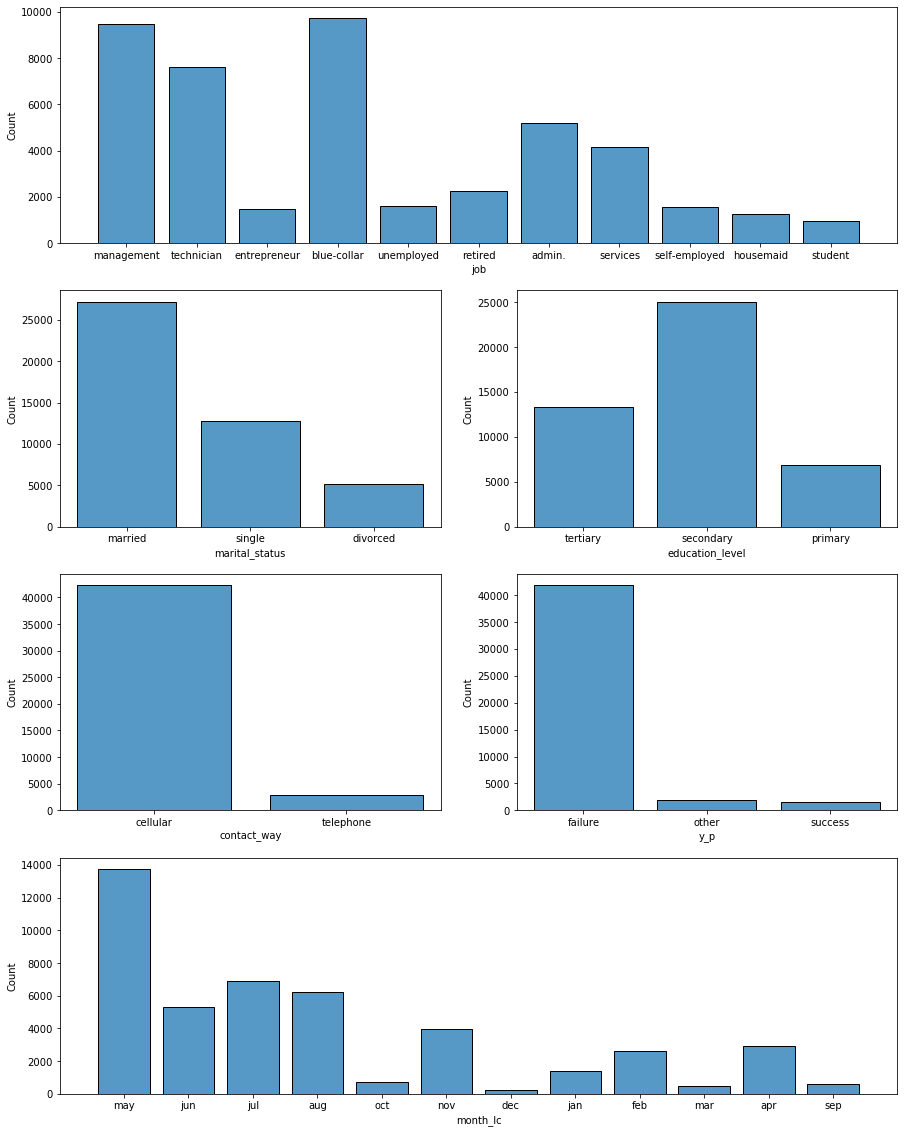

In [13]:
# CONSERTAR ORDEM DO ULTIMO GRAFICO

plt.figure(figsize = [15, 20])

plt.subplot(4, 1, 1)
sns.histplot(x = 'job', data = cat_attributes, shrink=.8)

plt.subplot(4, 2, 3)
sns.histplot(x = 'marital_status', data = cat_attributes, shrink=.8)

plt.subplot(4, 2, 4)
sns.histplot(x = 'education_level', data = cat_attributes, shrink=.8)

plt.subplot(4, 2, 5)
sns.histplot(x = 'contact_way', data = cat_attributes, shrink=.8)

plt.subplot(4, 2, 6)
sns.histplot(x = 'y_p', data = cat_attributes, shrink=.8)

plt.subplot(4, 1, 4)
sns.histplot(x = 'month_lc', data = cat_attributes, shrink=.8, hue_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'out', 'nov', 'dec']);

### 1.7.3. Booleans Attributes

In [14]:
bool_attributes.sample()

,default,housing_loan,loan,y
12031,False,False,False,False


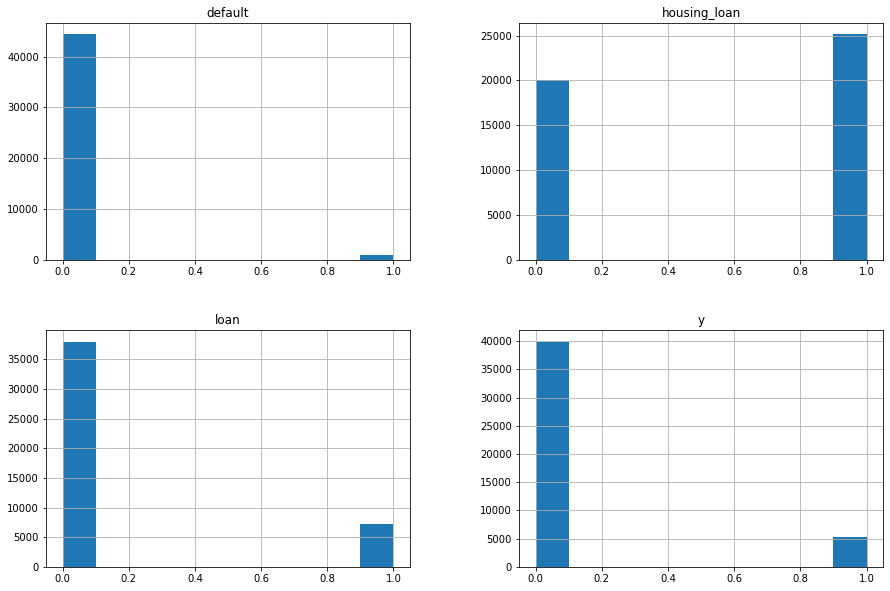

In [15]:
aux = bool_attributes.applymap(lambda x: 1 if x == True else 0)

aux.hist(figsize = [15, 10]);

# 2.0. FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

## 2.1. Hypotheses

**1.** Customers older than 50 are more likely to subscribe;

**2.** Unemployed customers are the most unlikely to subscribe;

**3.** Customers whose education level is secondary are more likely to subscribe;

**4.** Defaulted customers are not likely to subscribe;

**5.** Customers who have not defaulted but with debt tend to subscribe;

**6.**  Campaign calling may last longer if the customer subscribes;

**7.** First contact is the only one that matters;

**8.** People who subscribed to the last marketing campaign tend to subscribe to a new one.

## 2.2. Features

In [17]:
# Loans
df2['total_loan'] = (df2['loan'] | df2['housing_loan'])

# Datetimes
df2['month_lc_num'] = df2["month_lc"].apply(lambda x: datetime.datetime.strptime(x, "%b").month)
df2["date_lc"] = df2.apply(lambda x: datetime.datetime(year = 2022, month = x['month_lc_num'], day = x['day_of_month_lc']), axis = 1)
df2['week_of_year_lc'] = df2['date_lc'].dt.weekofyear
df2['weekday_lc'] = df2["date_lc"].apply(lambda x: x.weekday())

# 3.0. VARIABLES FILTERING

In [153]:
df3 = df2.copy()

## 3.1. Row Filtering

In [154]:
df3 = df3[(df3['default'] == 0) & (df3['balance'] >= 0)]

## 3.2. Columns Selection

In [155]:
drop_cols = ['contact_way', 'contact_count', 'loan', 'housing_loan', 'month_lc', 'date_lc', 'default']
df3 = df3.drop(drop_cols, axis = 1)

# 4.0. Exploratory Data Analysis (EDA)

In [156]:
df4 = df3.copy()

In [157]:
num_attributes_df4 = df4.select_dtypes(include = ['int64', 'float64'])
cat_attributes_df4 = df4.select_dtypes(exclude = ['int64', 'float64'])

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

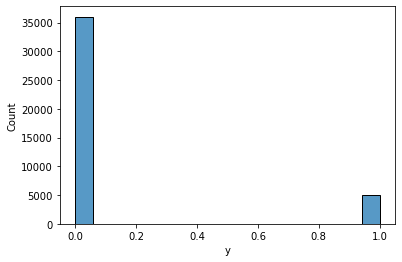

In [140]:
sns.histplot(df4['y'].apply(lambda x: int(x)));

### 4.1.2. Numerical Variable

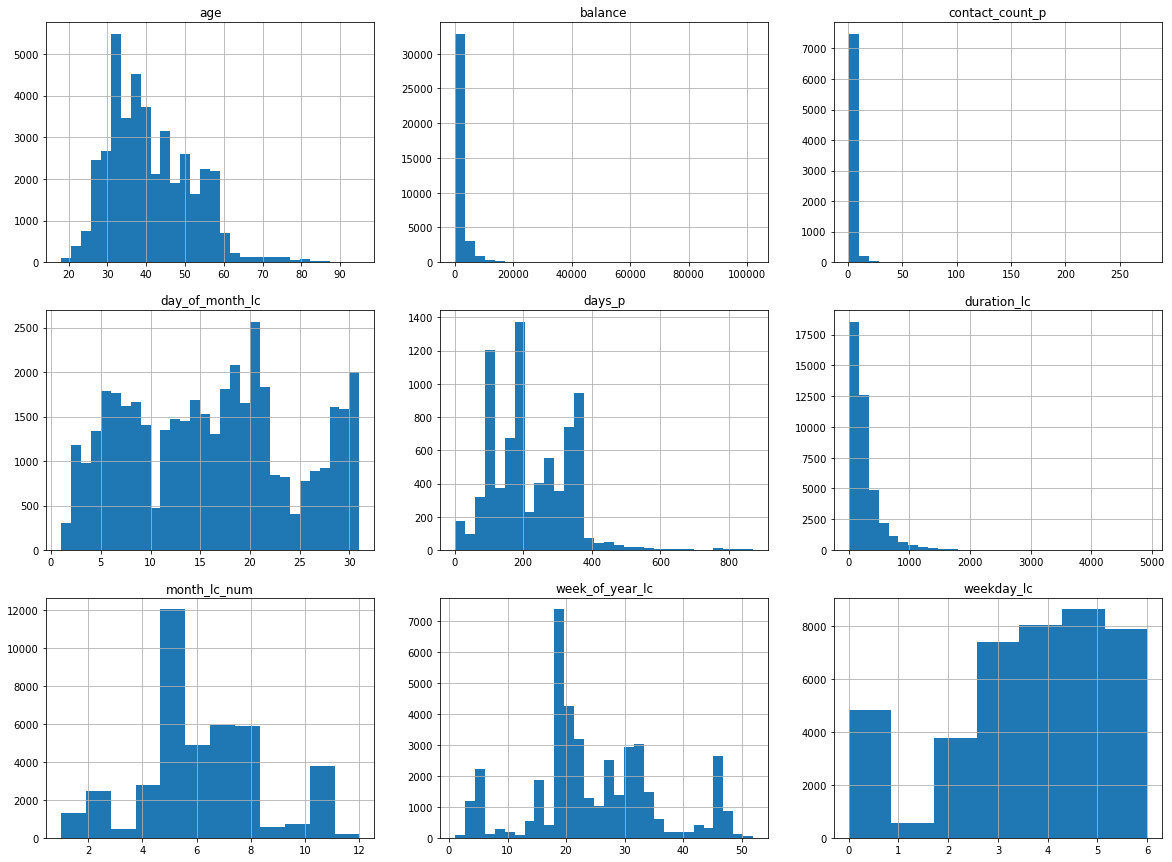

In [141]:
# AJEITAR LABEL DO ULTIMO GRAFICO

plt.figure(figsize = [20, 15])

# age
plt.subplot(3, 3, 1)
num_attributes_df4['age'].hist(bins = 30);
plt.title("age")

# balance
plt.subplot(3, 3, 2)
aux = num_attributes_df4[num_attributes_df4['balance'] > 0]['balance']
aux.hist(bins = 30);
plt.title("balance")

# contact_count_p
plt.subplot(3, 3, 3)
aux = num_attributes_df4[num_attributes_df4['contact_count_p'] > 0]['contact_count_p']
aux.hist(bins = 30);
plt.title("contact_count_p")

# day_of_month_lc
plt.subplot(3, 3, 4)
num_attributes_df4["day_of_month_lc"].hist(bins = 30);
plt.title("day_of_month_lc")

# days_p
plt.subplot(3, 3, 5)
aux = num_attributes_df4[num_attributes_df4['days_p'] > 0]['days_p']
aux.hist(bins = 30);
plt.title("days_p")

# duration_lc
plt.subplot(3, 3, 6)
num_attributes_df4['duration_lc'].hist(bins = 30);
plt.title("duration_lc")

# month_lc_num
plt.subplot(3, 3, 7)
num_attributes_df4['month_lc_num'].hist(bins = 12);
plt.title("month_lc_num")

# week_of_year_lc
plt.subplot(3, 3, 8)
num_attributes_df4['week_of_year_lc'].hist(bins = 30);
plt.title("week_of_year_lc")

# weekday_lc
plt.subplot(3, 3, 9)
num_attributes_df4['weekday_lc'].hist(bins = 7);
plt.title("weekday_lc");

### 4.1.3. Categorical Variable

## 4.2. Bivariate Analysis

### H1. Customers older than 50 are more likely to subscribe.
**False:** Customers younger than 50 are more likely to subscribe.

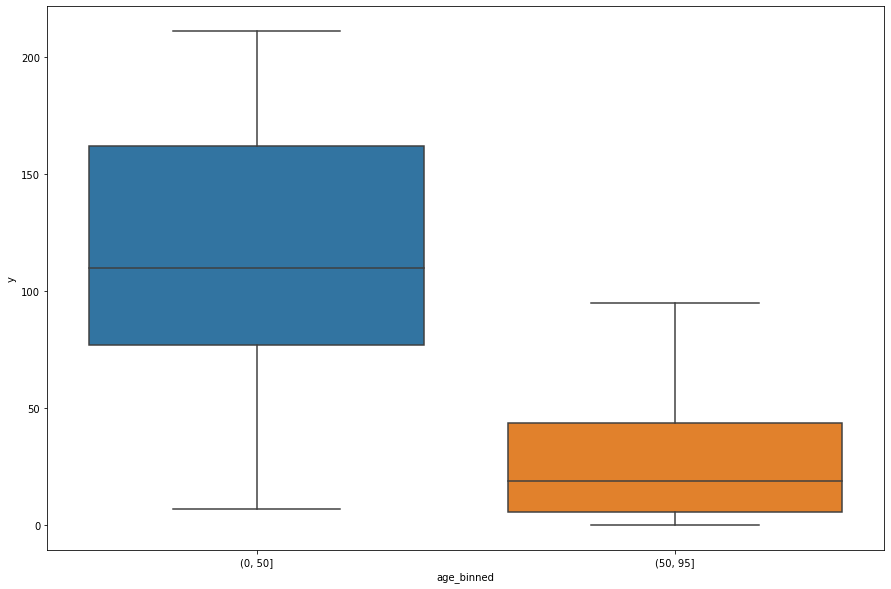

In [142]:
aux1 = df4.copy()[['age', 'y']].groupby('age').sum()['y'].reset_index()
aux2 = aux1.copy()

bins = [0, 50, aux1['age'].max()]
aux2['age_binned'] = pd.cut(aux1['age'], bins = bins)

plt.figure(figsize = [15, 10])
sns.boxplot(x = 'age_binned', y = 'y', data = aux2);

### H2. Unemployed customers are more likely not to subscribe.
**False:** The unemployed customers' subscription ratio is higher than the global ratio.

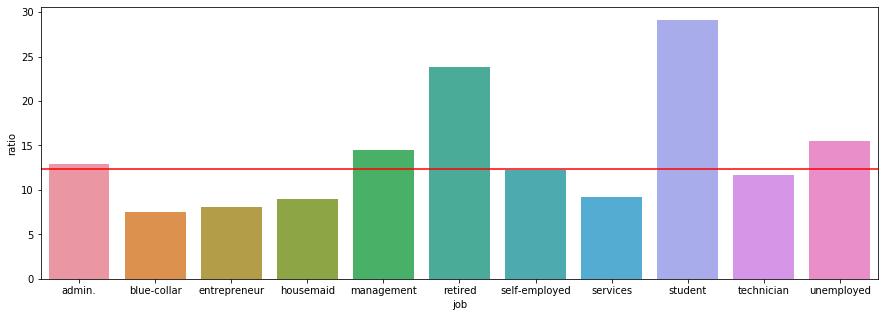

In [143]:
aux = df4.copy()[['job', 'y']]

aux2 = aux.groupby('job').count().reset_index()
aux2['subs'] = aux.groupby('job').sum().reset_index()['y']

global_ratio = aux['y'].sum()/aux.shape[0] * 100

aux2['ratio'] = aux2.apply(lambda x: x["subs"]/x['y'] * 100, axis = 1)

plt.figure(figsize = [15, 5])
ax = sns.barplot(x = 'job', y = 'ratio', data = aux2)
ax.axhline(y = global_ratio, color = 'red');

### H3. Customers whose education level is secondary are more likely to subscribe.
**False:** Customers whose education level is TERTIARY are more likely to subscribe

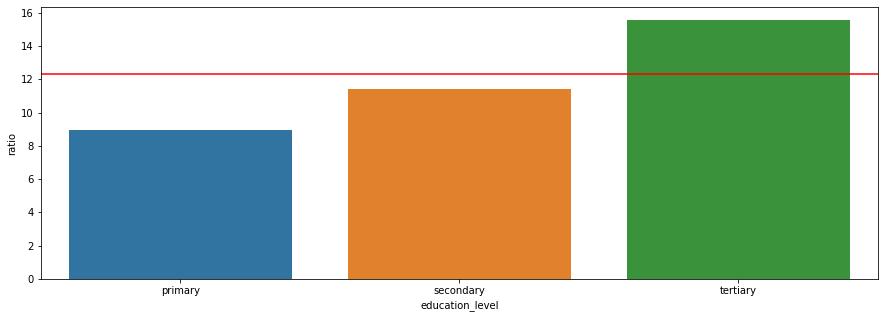

In [144]:
aux = df4.copy()[['education_level', 'y']]

aux2 = aux.groupby('education_level').count().reset_index()
aux2['subs'] = aux.groupby('education_level').sum().reset_index()['y']

global_ratio = aux['y'].sum()/aux.shape[0] * 100
aux2['ratio'] = aux2.apply(lambda x: x["subs"]/x['y'] * 100, axis = 1)

plt.figure(figsize = [15, 5])
ax = sns.barplot(x = 'education_level', y = 'ratio', data = aux2)
ax.axhline(y = global_ratio, color = 'red');

### H4. <s>Defaulted customers are not likely to subscribe;</s>
**-** Defaulted customers are already discarded.

### H5. Customers who have not defaulted but with debt tend to subscribe.
**False:** Customers who have not defaulted but with debt DO NOT tend to subscribe.

Text(0, 0.5, 'y Sum')

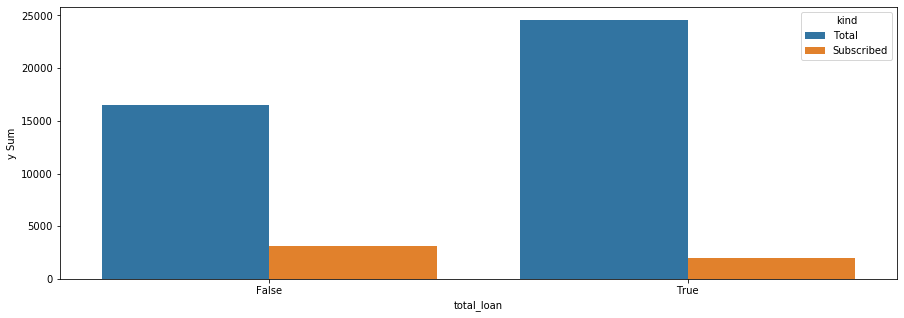

In [145]:
aux1 = df4.copy()[['total_loan', "default", 'y']]
aux1 = aux1[aux1['default'] == 0]
aux1 = aux1.drop('default', axis = 1)

aux2 = aux1.groupby('total_loan').count().reset_index()
aux2['kind'] = ['Total', "Total"]

aux3 = aux1.groupby('total_loan').sum().reset_index()
aux3['kind'] = ['Subscribed', "Subscribed"]

aux4 = pd.concat([aux2, aux3], axis = 0)


plt.figure(figsize = [15, 5])
sns.barplot(x = 'total_loan', y = 'y', data = aux4, hue = 'kind')
plt.ylabel("y Sum")

### H6. Campaign calling may last longer if the customer subscribes.
**Truth:** Customers that will subscribe tend to have a longer calling.

(-100, 2000)

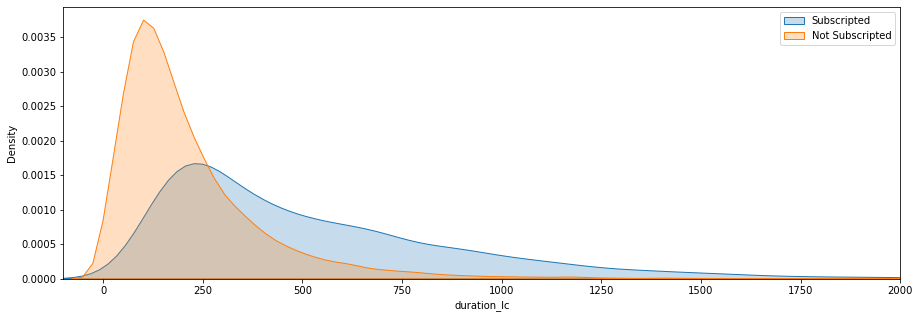

In [146]:
# REVER -1


aux = df4.copy()[['duration_lc', 'y']]

plt.figure(figsize = [15, 5])
sns.kdeplot(x = 'duration_lc', data = aux[aux['y'] == True], shade = True)
sns.kdeplot(x = 'duration_lc', data = aux[aux['y'] == False], shade = True)
plt.legend(["Subscripted", "Not Subscripted"])
plt.xlim([-100, 2000])

### H7. First contact is the only one that matters.
**False:** The number of contacts is not relevant information to predict subscription.

(-3, 20)

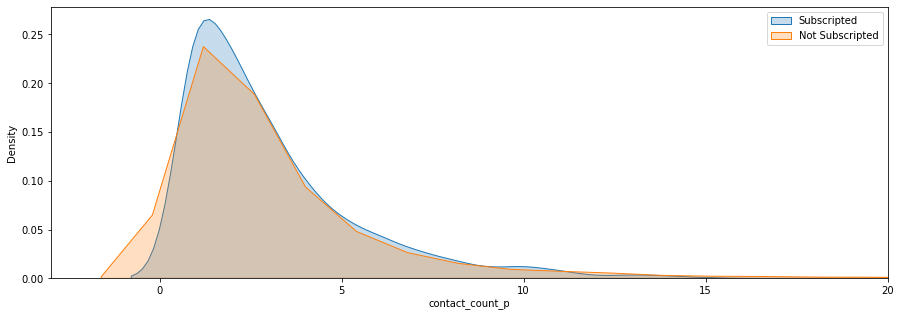

In [147]:
aux = df4[df4['contact_count_p'] != 0][['contact_count_p', 'y_p']]

plt.figure(figsize = [15, 5])
sns.kdeplot(x = 'contact_count_p', data = aux[aux['y_p'] == "success"], shade = True)
sns.kdeplot(x = 'contact_count_p', data = aux[aux['y_p'] != 'success'], shade = True)
plt.legend(["Subscripted", "Not Subscripted"])
plt.xlim([-3, 20])

### H8. People who subscribed to the last marketing campaign tend to subscribe to a new one.
**Truth** Around 65% of people who subscribed to the last campaign subscribed to the new one.

In [148]:
aux = df4.copy()[['y_p', 'y']]
aux['y_p'] = aux['y_p'].replace(to_replace = ['failure', 'success', 'other'], value = [False, True, False])
aux['count'] = np.ones(aux.shape[0])
aux2 = aux.groupby(['y_p', 'y']).sum()

TT = float(aux2.loc[(True, True)])
TF = float(aux2.loc[(True, False)])

print("{:.2f}%".format(TT/(TT+TF) * 100))
aux2

64.93%


count
y_p   y             
False False  35491.0
      True    4085.0
True  False    524.0
      True     970.0

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

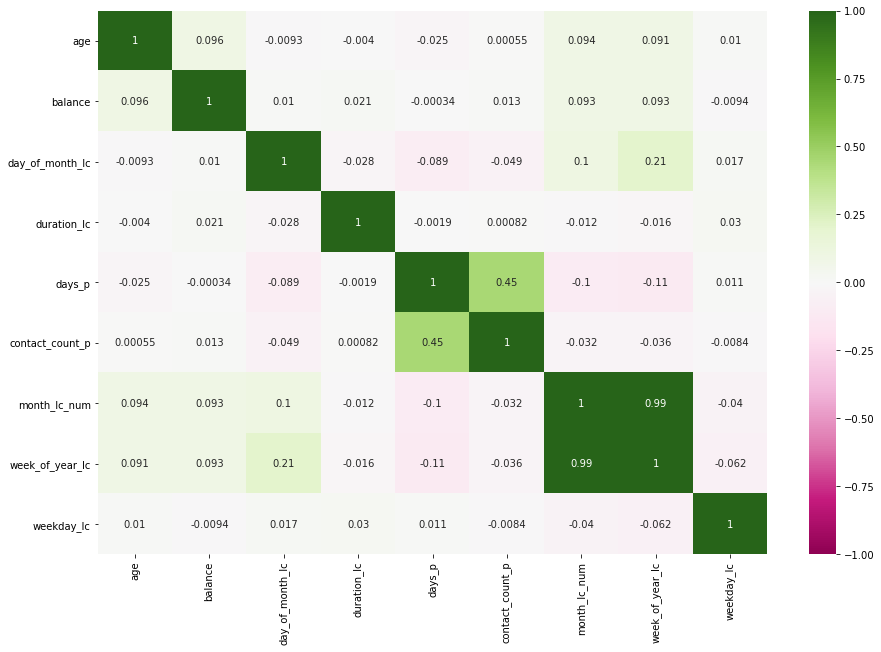

In [159]:
plt.figure(figsize = [15, 10])
sns.heatmap(data = num_attributes_df4.corr(), cmap = "PiYG", vmin = -1, vmax = 1, annot = True)
plt.yticks(rotation = 0);

### 4.3.2. Categorical Attributes

In [161]:
cat_corr_dict = {}
for i in cat_attributes_df4.columns:
    cat_corr_dict[i] = []
    for j in cat_attributes_df4.columns:
        cat_corr_dict[i].append(cramer_v(cat_attributes_df4[i], cat_attributes_df4[j]))
        
cat_corr_pd = pd.DataFrame(cat_corr_dict)
cat_corr_pd.index = cat_corr_pd.columns

<ipython-input-133-6289d10a7e76>:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  confusion_matrix = pd.crosstab(df1, df2).as_matrix()


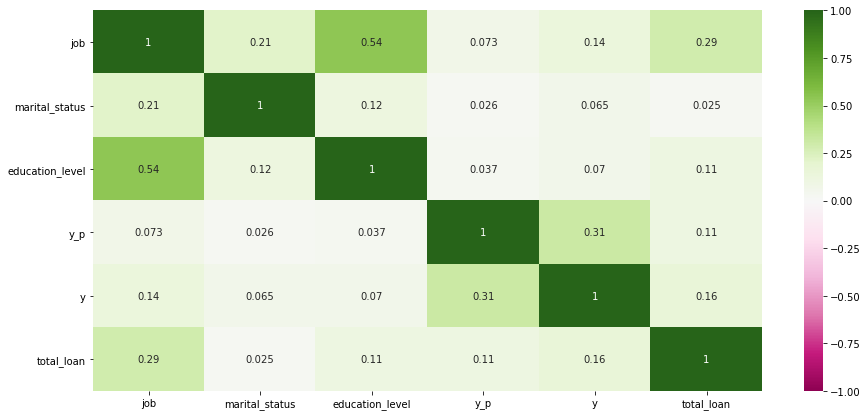

In [167]:
plt.figure(figsize = [15, 7])
sns.heatmap(data = cat_corr_pd, cmap = "PiYG", vmin = -1, vmax = 1, annot = True)
plt.yticks(rotation = 0);